

> # **Motivation**



Hi, everyone, we are group 22. Our group intends to classify weather images first, and then convert severe weather images into clear images that are easier to identify. Our project has a wide range of application scenarios like autonomous driving. Specifically, Severe weather phenomena have various negative effects on transportation. As a source of information for vehicle sensors, the state of the environment is directly influenced by weather conditions. For camera-led multi-sensor fusion system which is one of the mainstream, it is particularly important to recognize the weather through images and obtain surrounding information based on clear pictures.

For the classification part, we tried three different networks and chose the one that performed the best which is resnet101. Firstly, we dowanload data from kaggle and divide labeled data into 5 classes which is Sunrise, Shine, Rainy, Foggy, Cloudy. This is what the raw data looks like.  We split the data into training set and validation set in a ratio of 2:1 and Resize image into 255:255. For training and validation set, the input is pictures and the output is the probability that the image belongs to each class. 

For practicality, we use videos recorded by in-car cameras downloaded from youtube as our test data. We use the code to capture a picture of the video every 30s, and output the probability of belonging to each weather based on the screenshot.

For the defrog and derain part, unfortunately, this part is quite challenging for us, we used cycle gan but did not get good results.

The purpose of image translation is to map the input
from the source domain to the target domain. Similar tasks
include image coloring, domain adaptation, data augmentation and so on. Transferring weather conditions is important for photographic style transfer. Although lots of approaches have been proposed in traditional image translation tasks, few of them can handle the multi-category weather translation task, since weather conditions have rich categories and highly complex semantic structures. 

Our project has a wide range of application scenarios. For example, we can classified the weather automatically and process bad weather pictures obtained by driving recorders to allow drivers to make better judgments. In view of the fact that the driving recorder is often installed behind the front windshield, using the wiper can ensure that the clarity of the picture will not be affected by the raindrops on the glass. Also, reversing cameras often get very blurry images due to bad weather. It can also help drivers get a better view based on similar ideas

In this Project Progress Report, we completed the first part of our project- weather classification. We divide the dataset accoring to 5 labels 'cloudy', 'foggy', 'rainy', 'shine', 'sunrise'. There is two ways of weather classification. Firstly, applied 5 classifiers for one image. Each classifier will return 0 or 1 to determine whether the picture belongs to corresponding weather. Through this classification method, we can judge whether the picture belongs to one of the five weather categories. Secondly, we built one classifier to identify which of the five weather categories an image belongs to. Because of the accuracy of the first classification method, we decided to use the second method. And achieved 94% accuracy on the validation set of 500 images and 100% accuracy on the test set of 30 images



> # **Import Data**


*   Our data is found on kaggle, and here is the kaggle dataset link : https://www.kaggle.com/datasets/vijaygiitk/multiclass-weather-dataset
*   Also, we upload the kaggle dataset into our drive and here is the shared drive link : https://drive.google.com/drive/folders/1vBxCKRGNq8gs9xU6i3F4AjWyZzAuMQmn?usp=sharing





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision.datasets as dset
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time


Resize each image into 255x255 size.

In [ ]:
data_transform = transforms.Compose([transforms.Resize((255,255)), 
                                      transforms.ToTensor()
                                     ])
dataset = dset.ImageFolder('/content/drive/MyDrive/whetherClassficiation/dataset', transform=data_transform)

In [ ]:
classes = dataset.classes
print(classes)
print(dataset.class_to_idx)
print(len(dataset.imgs))

['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
{'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4}
1500




# > **Visualization**


*   Below, we simply visualize some traing images related to five given weather types.





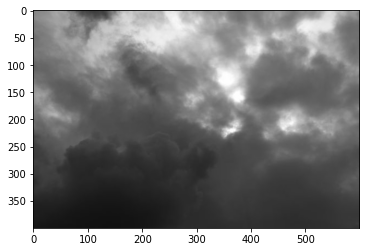

In [ ]:
a = dataset.imgs[0][0]
image=plt.imread(a)
# img = np.array(image)
plt.imshow(image)

In [ ]:
train_data, val_data = torch.utils.data.random_split(dataset, [1000, 500])

# train_data = dset.ImageFolder('/content/drive/MyDrive/Train', transform=data_transform)
# val_data = dset.ImageFolder('/content/drive/MyDrive/Val', transform=data_transform)
# test_data = dset.ImageFolder('/content/drive/MyDrive/Test', transform=data_transform)
print(len(train_data))
print(len(val_data))
# print(len(test_data))

# define dataloader parameters
batch_size  = 32
num_workers = 1

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
# test_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
#                                           num_workers=num_workers, shuffle=True)

1000
500


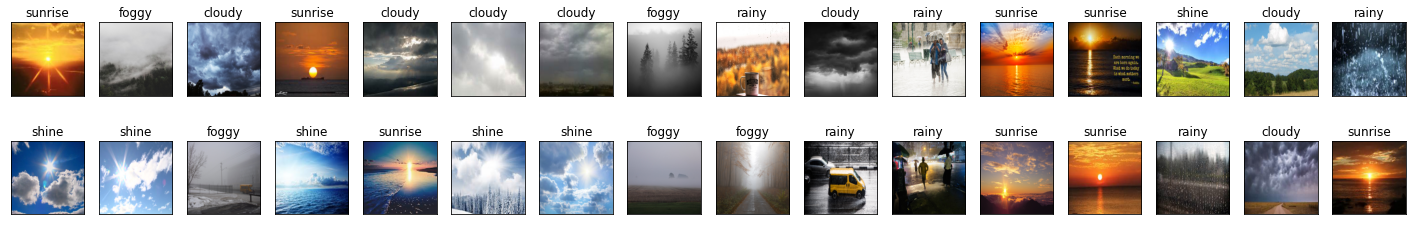

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(32):
    ax = fig.add_subplot(2, 32/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
images, labels = dataiter.next()
images.shape

torch.Size([32, 3, 255, 255])

In [ ]:
torch.cuda.is_available()

True



# > **CNN models - personal try**



In [ ]:
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch
import torch.nn as nn

In [ ]:
import math
class ConvClassifier(nn.Module):
    '''
    First layer : (3*224*224) --> (5*220*220) --> (5*110*110)
    Ssecond Layer : (5*110*110) --> (10*106*106) --> (10*53*53)
    Third Layer : (10*53*53) --> (20*44*44) --> (20*22*22), 
    I deleted the third layer, because it did not perform well.
    All the calculation is based on the basic default setting. 
    '''
    def __init__(self, k = [5, 5], o = [5, 10]):
        super(ConvClassifier, self).__init__()
        self.name = "Conv"

        self.conv1 = nn.Conv2d(3, o[0], k[0]) # in_channels = 3, out_chanels = 5, kernel_size = 5
        self.pool = nn.MaxPool2d(2, 2) # kernel_size = 2
        self.conv2 = nn.Conv2d(o[0], o[1], k[1]) # in_channels = 5, out_chanels = 10, kernel_size = 5
        # self.conv3 = nn.Conv2d(10, 20, 10) # in_channels = 10, out_chanels = 20, kernel_size = 5
        self.finalsize = o[1] * (math.floor((math.floor((224 - k[0] + 1) / 2) - k[1] + 1) / 2)) * (math.floor((math.floor((224 - k[0] + 1) / 2) - k[1] + 1) / 2))
        self.fc1 = nn.Linear(self.finalsize, 64)
        self.fc2 = nn.Linear(64, 9)
        # self.fc3 = nn.Linear(32, 9)

    def forward(self, x):
        # print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        # x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.finalsize)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.fc2(x)
        return x

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
import time

def get_accuracy(model, data):
    # if train:
    #     data = train_data
    # else:
    #     data = val_data

    correct = 0
    total = 0
    # print(len(torch.utils.data.DataLoader(data, batch_size=32)))
    # c = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=32):
        # print(c)
        # c += 1

        #############################################
        #To Enable GPU Usage
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        # print(pred)
        # print(labels)
        # print(sds)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train(model, d_train, d_val, batch_size=32, num_epochs=1, lr = 0.01):
    torch.manual_seed(1)

    train_loader = torch.utils.data.DataLoader(d_train, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        time0 = time.time()
        print('Epoch', epoch+1)
        for imgs, labels in iter(train_loader):
            #############################################
            #To Enable GPU Usage
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
            out = model(imgs)             # forward pass
            # print(out)
            # print(labels)
            loss = criterion(out, labels) # compute the total loss
            #print(sdsdsdsd)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, d_train)) # compute training accuracy 
        val_acc.append(get_accuracy(model, d_val))  # compute validation accuracy
        print('Iteration : ', n, 'th. Validation Acc : ', val_acc[-1], ', Training Acc : ', train_acc[-1])
        n += 1
        print('Epoch', epoch+1, ' Finifed. -----', time.time()-time0)
        

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


GPU kai le
Epoch 1
Iteration :  0 th. Validation Acc :  0.366 , Training Acc :  0.35
Epoch 1  Finifed. ----- 29.175549268722534
Epoch 2
Iteration :  1 th. Validation Acc :  0.566 , Training Acc :  0.585
Epoch 2  Finifed. ----- 28.886077642440796
Epoch 3
Iteration :  2 th. Validation Acc :  0.512 , Training Acc :  0.511
Epoch 3  Finifed. ----- 28.439249753952026
Epoch 4
Iteration :  3 th. Validation Acc :  0.644 , Training Acc :  0.63
Epoch 4  Finifed. ----- 29.676104307174683
Epoch 5
Iteration :  4 th. Validation Acc :  0.612 , Training Acc :  0.615
Epoch 5  Finifed. ----- 28.67756748199463
Epoch 6
Iteration :  5 th. Validation Acc :  0.612 , Training Acc :  0.615
Epoch 6  Finifed. ----- 29.03015375137329
Epoch 7
Iteration :  6 th. Validation Acc :  0.632 , Training Acc :  0.646
Epoch 7  Finifed. ----- 29.184739589691162
Epoch 8
Iteration :  7 th. Validation Acc :  0.626 , Training Acc :  0.628
Epoch 8  Finifed. ----- 28.673001050949097
Epoch 9
Iteration :  8 th. Validation Acc :  0.64

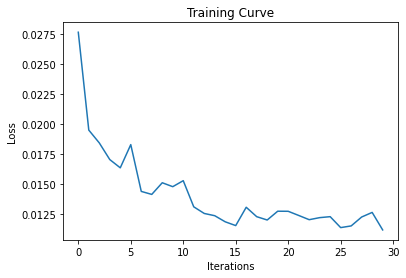

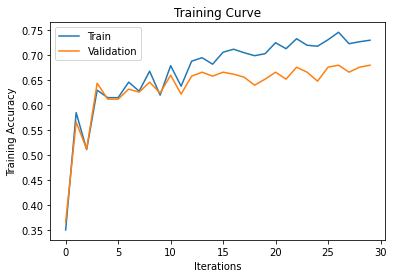

Final Training Accuracy: 0.73
Final Validation Accuracy: 0.68


In [ ]:
model2 = ConvClassifier(k=[40, 20], o = [10, 10])
use_cuda = True
if torch.cuda.is_available():
    print('GPU kai le')
    model2.cuda()

#proper model
train(model2, train_data, val_data, num_epochs=30, lr = 0.001, batch_size = 64)



# **> Pre-trained model, Resnet101 and VGG-16**



To improve the accuracy, then we use pretrained model.


Vgg as a classic model, it proves that increasing the depth of the network can affect the final performance of the network to a certain extent. He participated in the ImageNet Image Classification and Positioning Challenge in 2010, and achieved excellent results in ranking second in the classification task and first in the positioning task.


In resnet, with the introduction of Residual blocks, the problem of training very deep networks has been alleviated, and the ResNet model is composed of Residual blocks.

"Skip connection", is the core of the residual block. The output is not the same because of this skip connection. If there are no skip connections, the input X will be multiplied by the weight of the layer, and then a bias term will be added. Then the activation function f(), we get the output as H(x).

H(x)=f( wx + b ) or H(x)=f(x)

These skip connection techniques in ResNet address the problem of vanishing gradients in deep CNNs by allowing alternative shortcuts for gradients to flow through. Furthermore, skip connections help if any layer hurts the performance of the architecture, then it will be regularized skip.

In [ ]:
from torchvision import models

res101 = models.resnet101(pretrained = True)

vgg19 = models.vgg19_bn(pretrained = True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
numfits = res101.fc.in_features
res101.fc = nn.Linear(numfits, 5)

In [ ]:
def train2(model, d_train, d_val, batch_size=32, num_epochs=1, lr = 0.01):
    torch.manual_seed(1)

    train_loader = torch.utils.data.DataLoader(d_train, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        time0 = time.time()
        print('Epoch', epoch+1)
        for imgs, labels in iter(train_loader):
            #############################################
            #To Enable GPU Usage
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
            out = model(imgs)             # forward pass
            # print(out)
            # print(labels)
            loss = criterion(out, labels) # compute the total loss
            #print(sdsdsdsd)
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, d_train)) # compute training accuracy 
        val_acc.append(get_accuracy(model, d_val))  # compute validation accuracy
        print('Iteration : ', n, 'th. Validation Acc : ', val_acc[-1], ', Training Acc : ', train_acc[-1])
        n += 1
        print('Epoch', epoch+1, ' Finifed. -----', time.time()-time0)
        

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


GPU kai le
Epoch 1
Iteration :  0 th. Validation Acc :  0.934 , Training Acc :  0.971
Epoch 1  Finifed. ----- 168.96563506126404
Epoch 2
Iteration :  1 th. Validation Acc :  0.956 , Training Acc :  0.994
Epoch 2  Finifed. ----- 54.10765314102173
Epoch 3
Iteration :  2 th. Validation Acc :  0.96 , Training Acc :  0.997
Epoch 3  Finifed. ----- 55.10741949081421
Epoch 4
Iteration :  3 th. Validation Acc :  0.958 , Training Acc :  1.0
Epoch 4  Finifed. ----- 55.870713233947754
Epoch 5
Iteration :  4 th. Validation Acc :  0.958 , Training Acc :  1.0
Epoch 5  Finifed. ----- 55.68286609649658
Epoch 6
Iteration :  5 th. Validation Acc :  0.962 , Training Acc :  1.0
Epoch 6  Finifed. ----- 55.03633403778076
Epoch 7
Iteration :  6 th. Validation Acc :  0.96 , Training Acc :  1.0
Epoch 7  Finifed. ----- 55.92569351196289
Epoch 8
Iteration :  7 th. Validation Acc :  0.958 , Training Acc :  1.0
Epoch 8  Finifed. ----- 55.234891176223755


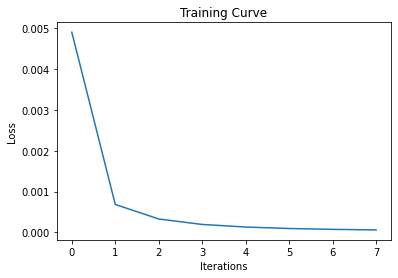

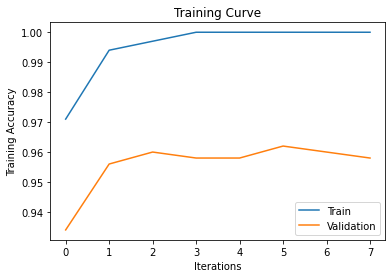

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.958


In [ ]:
model3 = res101
use_cuda = True
if torch.cuda.is_available():
    print('GPU kai le')
    model3.cuda()

#proper model
train2(model3, train_data, val_data, num_epochs=8, lr = 0.001, batch_size = 32)

In [ ]:
# VGG - modified model

class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

GPU kai le
Epoch 1
Iteration :  0 th. Validation Acc :  0.692 , Training Acc :  0.736
Epoch 1  Finifed. ----- 53.092230796813965
Epoch 2
Iteration :  1 th. Validation Acc :  0.696 , Training Acc :  0.76
Epoch 2  Finifed. ----- 52.1741943359375
Epoch 3
Iteration :  2 th. Validation Acc :  0.724 , Training Acc :  0.843
Epoch 3  Finifed. ----- 55.98659873008728
Epoch 4
Iteration :  3 th. Validation Acc :  0.71 , Training Acc :  0.819
Epoch 4  Finifed. ----- 54.77535390853882
Epoch 5
Iteration :  4 th. Validation Acc :  0.742 , Training Acc :  0.847
Epoch 5  Finifed. ----- 54.90636372566223
Epoch 6
Iteration :  5 th. Validation Acc :  0.774 , Training Acc :  0.883
Epoch 6  Finifed. ----- 54.97823643684387
Epoch 7
Iteration :  6 th. Validation Acc :  0.786 , Training Acc :  0.893
Epoch 7  Finifed. ----- 55.043556213378906
Epoch 8
Iteration :  7 th. Validation Acc :  0.784 , Training Acc :  0.91
Epoch 8  Finifed. ----- 54.77931451797485
Epoch 9
Iteration :  8 th. Validation Acc :  0.79 , Tra

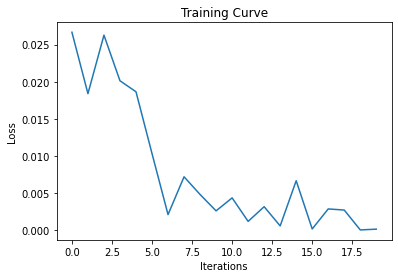

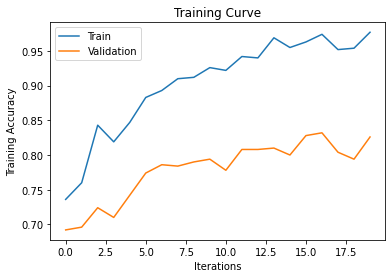

Final Training Accuracy: 0.977
Final Validation Accuracy: 0.826


In [ ]:
model4 = VGG16()
use_cuda = True
if torch.cuda.is_available():
    print('GPU kai le')
    model4.cuda()

#proper model
train2(model4, train_data, val_data, num_epochs=20, lr = 0.002, batch_size = 32)



# **> Test data, 30 pictures**


*   For the first try on testing, we test on the originally splitted test data, which belongs to kaggle data resource.





In [ ]:
testdataset = dset.ImageFolder('/content/drive/MyDrive/whetherClassficiation/alien_test', 
                               transform=data_transform)
classest = testdataset.classes
print(classest)
print(testdataset.class_to_idx)
print(len(testdataset.imgs))

['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
{'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4}
30


In [ ]:
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

In [ ]:
len(testdataset)

30

For testing Resnet101

In [ ]:
get_accuracy(model3, testdataset)

1.0

For testing VGG16

In [ ]:
get_accuracy(model4, testdataset)

0.8

# **Test Data, screen shot on video**


*   For the second try of testing, we used yoturb video depend on each weather condition. Because we are using our model to real-world, we need to see how our model perform on the real-world weather classification at driving.


*   The shared link on drive about five yoturb video is below : https://drive.google.com/drive/folders/10E1oLFdjpivQNiQnFSVpzDtjwNuo5Yu9?usp=sharing





In [ ]:
import cv2

For yoturb, data, we can use cv2 library to get the instant image every 24 frames. So that we could easily created the testing data from the yoturb recorded by car camera. For every weather, we created one corresponding image folder. 

In [ ]:
# Processing the data from yoturb video

rainvideo = '/content/drive/MyDrive/whetherClassficiation/Video/rain-video.mp4'
fogvideo = '/content/drive/MyDrive/whetherClassficiation/Video/fog-video.mp4'
cloudyvideo = '/content/drive/MyDrive/whetherClassficiation/Video/cloudy-video.mp4'
shinevideo = '/content/drive/MyDrive/whetherClassficiation/Video/shine-video.mp4'
sunrisevideo = '/content/drive/MyDrive/whetherClassficiation/Video/sunrise-video.mp4'

# 1 second = 48 nmber of frames
vc = cv2.VideoCapture(shinevideo)
f = 1
i = 1
if vc.isOpened():  
    rval, frame = vc.read()
else:
    rval = False

timeF = 24
while rval:  
    rval, frame = vc.read()
    if f % timeF == 0:  
        cv2.imwrite(f'/content/drive/MyDrive/whetherClassficiation/Video_test/shine/shine_{i}' + '.jpg', frame)  

        i = i + 1
        print("i："+str(i)+',frame:'+str(f))
    f = f + 1
    cv2.waitKey(1)


vc.release()
print(' -------------- Shine is done ---------------')

vc = cv2.VideoCapture(sunrisevideo)
f = 1
i = 1
if vc.isOpened():  
    rval, frame = vc.read()
else:
    rval = False


timeF = 24
while rval:  
    rval, frame = vc.read()
    if f % timeF == 0:  
        cv2.imwrite(f'/content/drive/MyDrive/whetherClassficiation/Video_test/sunrise/sunrise_{i}' + '.jpg', frame)  

        i = i + 1
        print("i："+str(i)+',frame:'+str(f))
    f = f + 1
    cv2.waitKey(1)


vc.release()
print(' -------------- Sunrise is done ---------------')

vc = cv2.VideoCapture(rainvideo)
f = 1
i = 1
if vc.isOpened():  
    rval, frame = vc.read()
else:
    rval = False

timeF = 24
while rval:  
    rval, frame = vc.read()
    if f % timeF == 0:  
        cv2.imwrite(f'/content/drive/MyDrive/whetherClassficiation/Video_test/rainy/rain_{i}' + '.jpg', frame)  

        i = i + 1
        print("i："+str(i)+',frame:'+str(f))
    f = f + 1
    cv2.waitKey(1)


vc.release()
print(' -------------- Rainy is done ---------------')

vc = cv2.VideoCapture(fogvideo)
f = 1
i = 1
if vc.isOpened():  
    rval, frame = vc.read()
else:
    rval = False

timeF = 24
while rval:  
    rval, frame = vc.read()
    if f % timeF == 0:  
        cv2.imwrite(f'/content/drive/MyDrive/whetherClassficiation/Video_test/foggy/foggy_{i}' + '.jpg', frame)  

        i = i + 1
        print("i："+str(i)+',frame:'+str(f))
    f = f + 1
    cv2.waitKey(1)


vc.release()
print(' -------------- Foggy is done ---------------')





i：2,frame:24
i：3,frame:48
i：4,frame:72
i：5,frame:96
i：6,frame:120
i：7,frame:144
i：8,frame:168
i：9,frame:192
i：10,frame:216
 -------------- Shine is done ---------------
i：2,frame:24
i：3,frame:48
i：4,frame:72
i：5,frame:96
 -------------- Sunrise is done ---------------
i：2,frame:24
i：3,frame:48
i：4,frame:72
i：5,frame:96
i：6,frame:120
i：7,frame:144
i：8,frame:168
i：9,frame:192
 -------------- Rainy is done ---------------
i：2,frame:24
i：3,frame:48
i：4,frame:72
i：5,frame:96
i：6,frame:120
i：7,frame:144
i：8,frame:168
i：9,frame:192
 -------------- Foggy is done ---------------


In [ ]:
vc = cv2.VideoCapture(cloudyvideo)
f = 1
i = 1
if vc.isOpened():  
    rval, frame = vc.read()
else:
    rval = False

timeF = 24
while rval:  
    rval, frame = vc.read()
    if f % timeF == 0:  
        cv2.imwrite(f'/content/drive/MyDrive/whetherClassficiation/Video_test/cloudy/Cloud_{i}' + '.jpg', frame)  

        i = i + 1
        print("i："+str(i)+',frame:'+str(f))
    f = f + 1
    cv2.waitKey(1)


vc.release()
print(' -------------- Cloudy is done ---------------')

i：2,frame:24
i：3,frame:48
i：4,frame:72
i：5,frame:96
i：6,frame:120
i：7,frame:144
i：8,frame:168
i：9,frame:192
i：10,frame:216
i：11,frame:240
i：12,frame:264
i：13,frame:288
i：14,frame:312
 -------------- Cloudy is done ---------------


Here we import the processed image data from previous step to test the real-world driving.

In [ ]:
testdataset2 = dset.ImageFolder('/content/drive/MyDrive/whetherClassficiation/Video_test', 
                               transform=data_transform)
classest2 = testdataset2.classes
print(classest2)
print(testdataset2.class_to_idx)
print(len(testdataset2.imgs))

['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
{'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4}
42


In [ ]:
test_loader2 = torch.utils.data.DataLoader(testdataset2, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

For testing Resnet101

In [ ]:
get_accuracy(model3, testdataset2)

0.8571428571428571

For testing VGG16

In [ ]:
get_accuracy(model4, testdataset2)

0.5



# **> Summary**



Our testing result on real-driving video shows that resnet101 is the best model among our three models. However,  the accuracy is still worth of improving.
There are several points that our model need to improve.


*   Because we are supposed to train a model on recoginizing weather condition while driving, we could add some data from driving car carmera. Our training model do not include many pictures on that. The reason why we do not include any images into the training could be stated in two main points. First, the car camera video is hard to find, either searching on yoturb or recording by ourselves is time-consuming and difficult. Secondly, we want to see the performance of just trainig model with regular weather images. As shown until, the best performance on test data set is around 85 % . We can say this result is relatively good because of our limit on training data. If we add some picture while driving into the training part, we could possibly get a higher test accuracy on real-world.
*   Our next step is going toward "how we could make use of our correctly identitied weather". What is the use of "weather classification" ? Once we recognize the current weather, like raniy or foggy. Could we make the image more clear ? One possible discussion among our group is to think about using SVD, dimension reduction, to get rid of the background. However, it does not help because drivers still need to watch the road even thought he current weather is rainy or foggy. Then we search for the method to clear the fog and rain so that we could let the driver see more clear about what is going on. 

